In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_dense_adj
from src.dominant import (
    DOMINANTAugmented,
)  # note we're using the custom DOMINANTAugmented class here
from tqdm import tqdm  #
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from typing import Dict, Tuple
import numpy as np
from src.loaders import load_elliptic, make_loader
from src.traditional_models import train_traditional_classifier
from main import load_dataset, create_model, create_loader, train_model, test_model
import argparse
import warnings
import yaml

In [53]:
def plot_loss(
    loss_history,
    attr_loss_history,
    struct_loss_history,
    output_directory="./outputs",
    timestamp: str = None,
) -> None:
    """
    Plot the training loss

    Args:
        loss_history: The loss history
        attr_loss_history: The attribute loss history
        struct_loss_history: The structure loss history
        output_directory (str): Directory to save the plot

    Returns:
        None
    """
    # timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, "o-", label="Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title("Training Loss History")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(attr_loss_history) + 1),
        attr_loss_history,
        "o-",
        label="Attribute Loss",
    )
    plt.plot(
        range(1, len(struct_loss_history) + 1),
        struct_loss_history,
        "o-",
        label="Structure Loss",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title("Attribute and Structure Loss History")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
config = {
            # Model parameters
            "num_layers": 3,
            "hidden_dim": 64,
            "num_heads": 4,
            "dropout": 0.1,
            "backbone": "hybrid",
            "apply_augmentation": False,
            "use_interpolation": False,
            "use_perturbation": False,
            "interpolation_rate": 0.1,
            "feature_noise": 0.05,
            "structure_noise": 0.05,
            "use_adaptive_alpha": False,
            "start_alpha": 0.6,
            "end_alpha": 0.5,
            "use_aggregation": False,
            "aggregation_mean": False,
            "aggregation_max": False,
            # Training parameters
            "batch_size": 2048,
            "num_neighbors": [10, 10],
            "learning_rate": 0.001,
            "num_epochs": 10,
            # Paths for output
            "data_root": "data/elliptic",
            "save_dir": "./saved_models",
            # threshold for our testing
            "threshold": 0.8,
            # transfer learning options
            "transfer_learning": True,
            "classifiers": ["rf", "mlp"],
            "load_model_path": None,
        }

Using adaptive alpha.
Using HybridGCNGATBackbone as backbone, with 3 layers.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
Current alpha: 0.6000


Epochs:  10%|█         | 1/10 [00:10<01:30, 10.02s/it]

Avg Batch Loss: 4.156e+02, Avg Batch Attribute Loss: 1.728e+01, Avg Batch Structure Loss: 1.013e+03
Epoch 2/10
Current alpha: 0.5900


Epochs:  20%|██        | 2/10 [00:20<01:21, 10.14s/it]

Avg Batch Loss: 2.264e+02, Avg Batch Attribute Loss: 1.611e+01, Avg Batch Structure Loss: 5.291e+02
Epoch 3/10
Current alpha: 0.5800


Epochs:  30%|███       | 3/10 [00:30<01:10, 10.11s/it]

Avg Batch Loss: 1.366e+02, Avg Batch Attribute Loss: 1.508e+01, Avg Batch Structure Loss: 3.044e+02
Epoch 4/10
Current alpha: 0.5700


Epochs:  40%|████      | 4/10 [00:40<01:00, 10.09s/it]

Avg Batch Loss: 7.639e+01, Avg Batch Attribute Loss: 1.444e+01, Avg Batch Structure Loss: 1.585e+02
Epoch 5/10
Current alpha: 0.5600


Epochs:  50%|█████     | 5/10 [00:50<00:50, 10.12s/it]

Avg Batch Loss: 4.637e+01, Avg Batch Attribute Loss: 1.421e+01, Avg Batch Structure Loss: 8.730e+01
Epoch 6/10
Current alpha: 0.5500


Epochs:  60%|██████    | 6/10 [01:01<00:40, 10.24s/it]

Avg Batch Loss: 3.568e+01, Avg Batch Attribute Loss: 1.399e+01, Avg Batch Structure Loss: 6.219e+01
Epoch 7/10
Current alpha: 0.5400


Epochs:  70%|███████   | 7/10 [01:11<00:30, 10.16s/it]

Avg Batch Loss: 3.078e+01, Avg Batch Attribute Loss: 1.383e+01, Avg Batch Structure Loss: 5.067e+01
Epoch 8/10
Current alpha: 0.5300


Epochs:  80%|████████  | 8/10 [01:21<00:20, 10.23s/it]

Avg Batch Loss: 2.681e+01, Avg Batch Attribute Loss: 1.365e+01, Avg Batch Structure Loss: 4.165e+01
Epoch 9/10
Current alpha: 0.5200


Epochs:  90%|█████████ | 9/10 [01:31<00:10, 10.14s/it]

Avg Batch Loss: 2.472e+01, Avg Batch Attribute Loss: 1.347e+01, Avg Batch Structure Loss: 3.691e+01
Epoch 10/10
Current alpha: 0.5100


Epochs: 100%|██████████| 10/10 [01:41<00:00, 10.14s/it]

Avg Batch Loss: 2.499e+01, Avg Batch Attribute Loss: 1.337e+01, Avg Batch Structure Loss: 3.709e+01
Model saved to ./saved_models\dominant_model_2025-04-19_09_30.pt
Metrics saved to ./saved_models\train_metrics_2025-04-19_09_30.json


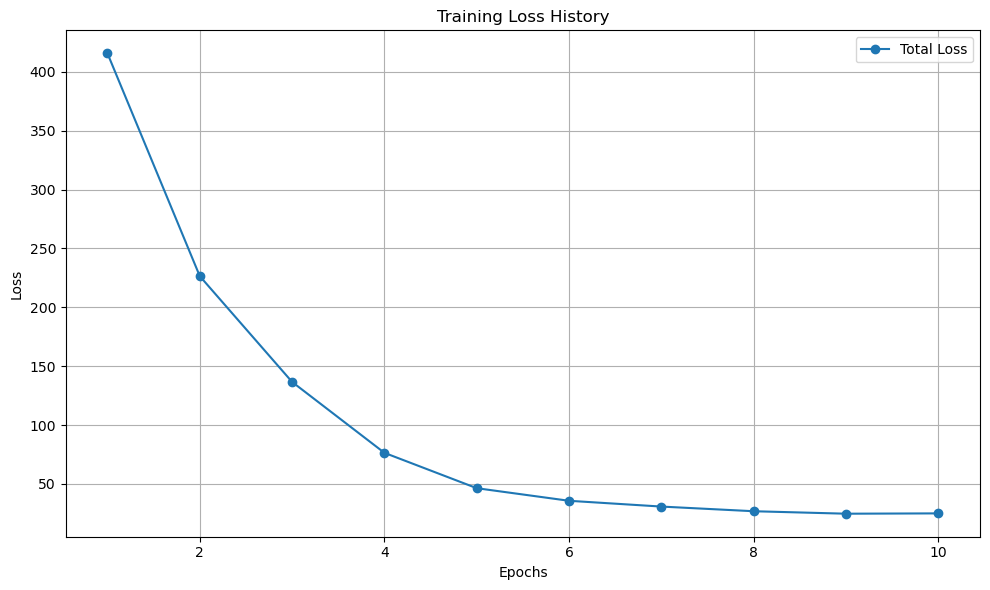

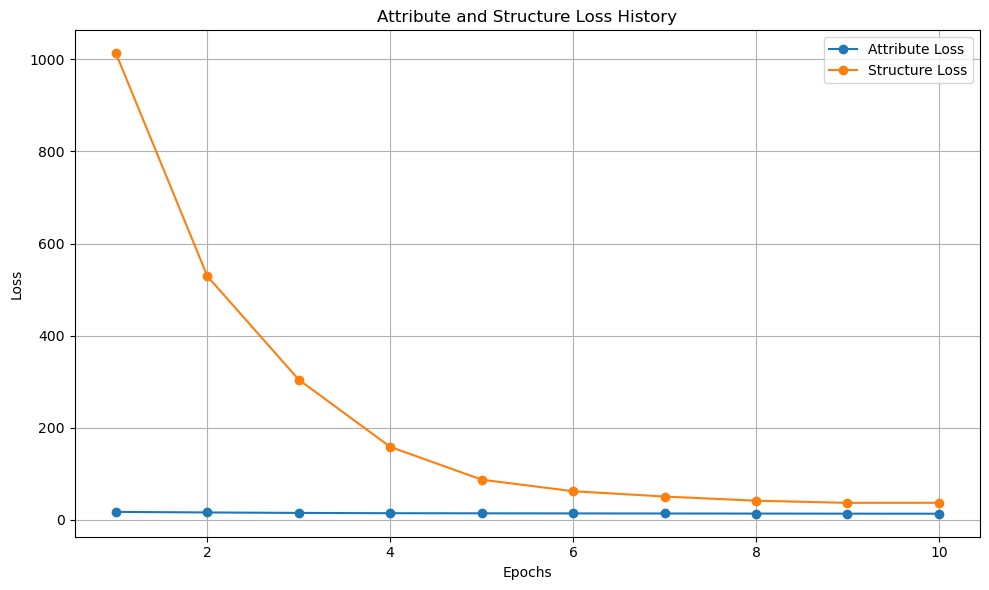

Model input dimension: 165
Data feature dimension: 165
Using aggregation: False


Testing: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Test Metrics:
AUC: 0.562
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.292e+02
Metrics saved to ./saved_models\test_metrics_2025-04-19_09_30.json


In [62]:
data = load_dataset(root=config["data_root"])

if config["load_model_path"] is None:
    model, device = create_model(data, config)

    train_loader = create_loader(data,batch_size=config["batch_size"], num_neighbors=config["num_neighbors"],use_train_mask=True)

    model, training_metrics = train_model(model,train_loader,learning_rate=config["learning_rate"],device=device,
                    num_epochs=config["num_epochs"],output_directory=config["save_dir"],timestamp=timestamp)
    plot_loss(training_metrics["loss_history"],training_metrics["attr_loss_history"],training_metrics["struct_loss_history"],
                    output_directory=config["save_dir"],timestamp=timestamp)

    test_metrics = test_model(model,data,device,batch_size=config["batch_size"],num_neighbors=config["num_neighbors"],
                output_directory=config["save_dir"],threshold=config["threshold"],timestamp=timestamp)